In [25]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import readgadget
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example straight from Jens

In [110]:
dir_name = "/scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/"

sim   = bacco.Simulation(basedir=dir_name + "0.00/",  halo_file="groups_030/fof_subhalo_history_tab_orph_wweight_030")

2024-01-19 18:42:04,895 bacco.sims : Initialising simulation Default
2024-01-19 18:42:04,896 bacco.sims : try /scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/0.00/groups_030/fof_subhalo_history_tab_orph_wweight_030
2024-01-19 18:42:04,931 bacco.sims : Loading /scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/0.00/groups_030/fof_subhalo_history_tab_orph_wweight_030
2024-01-19 18:42:04,944 bacco.cosmo :    initialization took 0.000 secs
2024-01-19 18:42:05,057 bacco.sims : ...done in 0.0504 s


In [111]:
# Define what variables we consider, "J2" means density and "J4" means Laplacian
variables = ("J2", "J4")
pbm = pb.ProbabilisticBiasManager(sim, variables=variables, damping_scale=0.15, ngrid=256) 

In [112]:
# Define what bias parameters we want to measure
# "J2" corresponds to b1, "J22" to b2, "J24" to bdeltaL, "J4" to bL, "J44" to bL**2
terms = ("J2", "J22", "J24", "J4", "J44")
model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=4)

2024-01-19 18:42:06,798 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.146 secs
2024-01-19 18:42:06,803 bacco.cosmo :    created Pk(z=0) tab from k 8.333333244081587e-05 to 100000.0 h/Mpc


In [113]:
# Define a set of tracers (here FoF groups selected by mass) and fit the bias. The error is estimate through a jackknife with 4**3 subboxes excluded one by one
m200b = sim.fof['halo_m200b'] * 1e10
mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 ) 
b, bcov = pbm.fit_bias(model=model_expansion, tracer_type="fof", mask=mask, error="jack4")

print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))

2024-01-19 18:42:18,270 bacco.sims : Reading 7902418 items for Group_M_Mean200
/tmp/ipykernel_223788/2828640615.py:3: RuntimeWarning: divide by zero encountered in log10
  mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 )
2024-01-19 18:42:21,878 bacco.sims : Reading 7902418 items for halo_firstsub
2024-01-19 18:42:23,696 bacco.sims : Reading 7902418 items for GroupNsubs
2024-01-19 18:42:25,442 bacco.sims : Reading 16313943 items for SnapBecameOrphan
2024-01-19 18:42:27,472 bacco.sims : Reading 16313943 items for SubhaloRankInGr
2024-01-19 18:42:31,469 bacco.sims : Reading 16313943 items for MostboundID
2024-01-19 18:42:33,861 bacco.sims : Reading 7902418 items for GroupLen


(1060, 3) (1060, 2)
b1 = 4.25 +- 0.31
b2 = 16.90 +- 3.54


Dope it works! just had to change np.bool --> bool

## let's try with quijote

Linear field

In [2]:
quijote_dir = '/dipc_storage/cosmosims/datashare/Quijote_data'

In [3]:
dens_yin = np.load(f'{quijote_dir}/Fiducial/ZA/200/den_200.npy')

In [4]:
box_size = 1000
ngrid = 512 

N-body sim

In [5]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=box_size, ndim=3, bounds=False)

In [6]:
sim_disp = np.load(f'{quijote_dir}/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=box_size,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-01-22 12:21:38,495 bacco.scaler : Adding displacement field with a vel-factor=0.000000


### let's create a bias field with known bias params 

In [7]:
k_nyq = np.pi * ngrid / box_size

damping_scale = k_nyq

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], ngrid=ngrid, ngrid1=ngrid, 
                         sdm=True, mode="dm", BoxSize=box_size,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale, 
                         bias_model='expansion', deposit_method="cic", 
                         use_displacement_of_nn=False, interlacing=False, 
                         )

2024-01-22 12:21:39,718 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [8]:
bias_terms_lag = bmodel.bias_terms_lag()

2024-01-22 12:21:42,296 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-01-22 12:21:42,297 bacco.BiasModel : fttw plan
2024-01-22 12:21:42,298 bacco.BiasModel : Computing linear field ...
2024-01-22 12:21:42,299 bacco.BiasModel : Memory used: 6.667558912 Gigabytes
2024-01-22 12:21:42,320 bacco.BiasModel : fttw freqs
2024-01-22 12:21:42,320 bacco.BiasModel : tidk freqs
2024-01-22 12:21:48,036 bacco.BiasModel : ifft
2024-01-22 12:22:19,313 bacco.BiasModel : Computing laplacian ...
2024-01-22 12:22:19,315 bacco.BiasModel : Memory used: 11.519627264 Gigabytes
2024-01-22 12:22:20,869 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-01-22 12:22:20,871 bacco.BiasModel : Memory used: 12.051984384 Gigabytes
2024-01-22 12:22:21,133 bacco.BiasModel : Computing delta squared ...
2024-01-22 12:22:21,135 bacco.BiasModel : Memory used: 12.588761088 Gigabytes
2024-01-22 12:22:22,255 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2

In [9]:
bias_terms_lag.shape

(5, 512, 512, 512)

In [11]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_terms_lag)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size, pos=sim_pos, 
                              mass = (bias_terms_lag[ii]).flatten(), deposit_method='cic', 
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2024-01-22 12:23:01,848 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-22 12:23:01,849 bacco.statistics : starting deposit 1
2024-01-22 12:23:02,840 bacco.statistics :  mesh done in 0.992 s
2024-01-22 12:23:03,315 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-22 12:23:03,316 bacco.statistics : starting deposit 1
2024-01-22 12:23:04,197 bacco.statistics :  mesh done in 0.882 s
2024-01-22 12:23:04,647 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-22 12:23:04,648 bacco.statistics : starting deposit 1
2024-01-22 12:23:05,532 bacco.statistics :  mesh done in 0.884 s
2024-01-22 12:23:06,108 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-22 12:23:06,109 bacco.statistics : starting deposit 1
2024-01-22 12:23:06,956 bacco.statistics :  mesh done in 0.848 s
2024-01-22 12:23:07,536 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=Fal

In [12]:
bias_terms_eul_sim.shape

(5, 1, 512, 512, 512)

In [13]:
from bacco.utils import sum_bias_model_terms_py

In [14]:
bias_vector = [0.5, 0.5, 1.0, -1.0]
halo_field_eul = sum_bias_model_terms_py(zeroth=bias_terms_eul_sim[0], 
                                         first=bias_terms_eul_sim[1],
                                         second=bias_terms_eul_sim[2], 
                                         tidal=bias_terms_eul_sim[3], 
                                         laplacian=bias_terms_eul_sim[4], 
                                         b1=bias_vector[0], b2=bias_vector[1], 
                                         b3=bias_vector[2], b4=bias_vector[3], ngrid=ngrid)
#if self.mean_num_dens is not None:
    #Vcell = (self.BoxSize/self.ngrid)**3.
    #halo_field_eul = halo_field_eul*self.mean_num_dens*Vcell
norm=ngrid**3.
halo_field_eul_norm = halo_field_eul/norm

In [15]:
# looks like theres a direct function if i dont care about the individual fields
# bias_vector = [0.5, 0.5, 1.0, -1.0]
# halo_field_eul = bmodel.get_eul_bias_field(bias_vector, bias_terms_lagrangian=bias_fields)

In [16]:
halo_field_eul.shape

(512, 512, 512)

In [17]:
print(bias_terms_eul_sim[0][0][0,0,:10])
print(halo_field_eul[0,0,:10])

[0.8979322  0.13886973 0.         0.08160638 0.48559746 0.43586278
 0.00380634 0.07616333 0.18782741 0.05929425]
[ 1.5745705   1.2264574   0.         -0.54167646 -1.4181274  -0.61939144
  0.00170922  0.6812594   1.5069001   0.6962192 ]


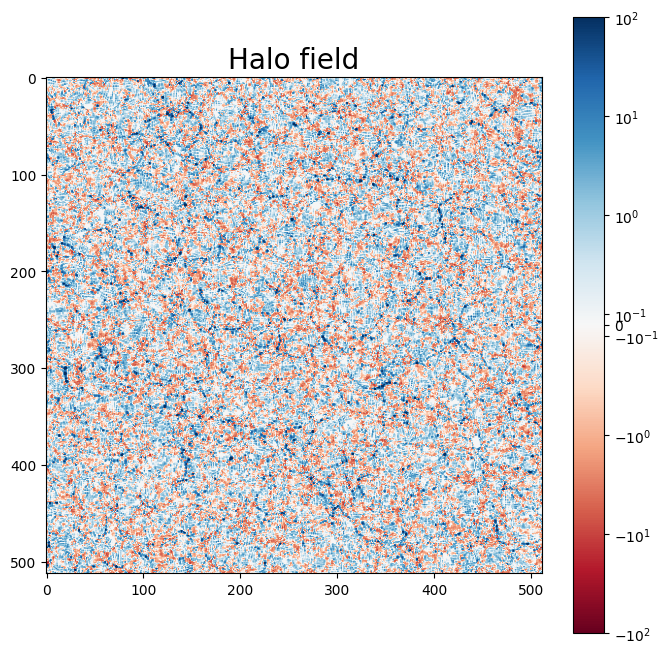

In [23]:
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.figure(figsize=(8,8))
plt.imshow(halo_field_eul[0,:,:], norm=norm, cmap='RdBu')
#plt.imshow(halo_field_eul[0,:,:])
plt.colorbar()
plt.title(r'Halo field', size=20)
plt.show()

and in lagrangian space:

In [19]:
halo_field_lag = sum_bias_model_terms_py(zeroth=bias_terms_lag[0], 
                                         first=bias_terms_lag[1],
                                         second=bias_terms_lag[2], 
                                         tidal=bias_terms_lag[3], 
                                         laplacian=bias_terms_lag[4], 
                                         b1=bias_vector[0], b2=bias_vector[1], 
                                         b3=bias_vector[2], b4=bias_vector[3], ngrid=ngrid)

In [20]:
np.min(halo_field_lag), np.max(halo_field_lag)

(-22.787374, 155.14108)

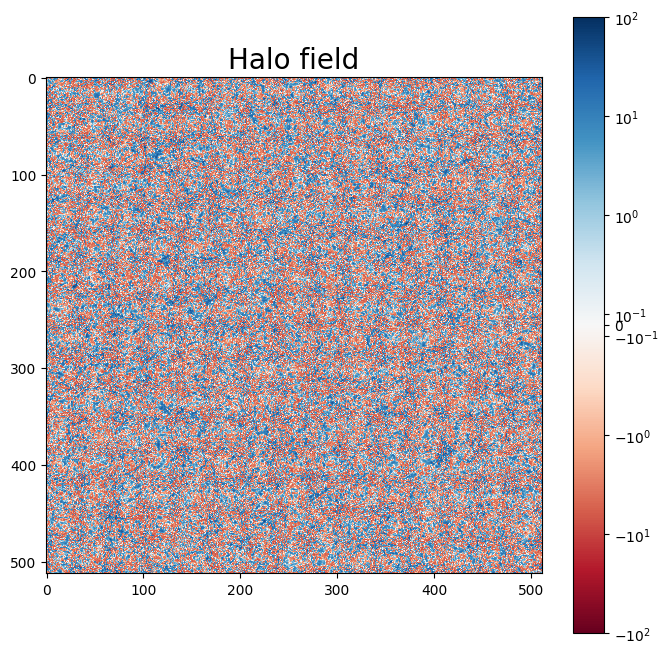

In [22]:
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.figure(figsize=(8,8))
plt.imshow(halo_field_lag[0,:,:], norm=norm, cmap='RdBu')
#plt.imshow(halo_field_eul[0,:,:])
plt.colorbar()
plt.title(r'Halo field', size=20)
plt.show()

### sample from the lagrangian space field:

In [ ]:
def sample(field):
    field_norm = field/np.max(field)
    rng = np.random.default_rng()
    random = rng.uniform(field_norm.shape)

### nevermind, too annoying to sample from

## and now we have the SAM ICs! vamos!

In [2]:
idx_sam = 0
redshift = 0
ndens_target = 0.003 # (Mpc/h)^-3

dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [3]:
fn_dat = f"{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5"

In [4]:
vol_hMpc = 100**3 # units Mpc/h!! 
n_target = int(ndens_target * vol_hMpc)
with h5py.File(fn_dat, 'r') as f:
    mstar_raw = np.array(f['mstar'])
    i_target = np.argsort(mstar_raw)[::-1][:n_target] # order by mstar and take largest to smallest to get desired ndens
    x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
    pos_arr = np.array([x_arr, y_arr, z_arr]).T
    pos_arr = pos_arr[i_target]

In [5]:
pos_arr.shape

(3000, 3)

In [6]:
h = 0.6711
pos_arr_hMpc = pos_arr*h
np.shape(pos_arr_hMpc), np.min(pos_arr_hMpc), np.max(pos_arr_hMpc)

# don't know why negative!! for now just cut - but TODO understand
i_neg = np.any(pos_arr_hMpc<0,axis=1)
print(i_neg.shape)
print(i_neg)
print(np.sum(i_neg))
pos_arr_hMpc = pos_arr_hMpc[~i_neg,:]
np.shape(pos_arr_hMpc), np.min(pos_arr_hMpc), np.max(pos_arr_hMpc)

(3000,)
[False False False ... False False False]
1


((2999, 3), 0.005335211445000001, 99.98718900000001)

Text(0, 0.5, '$y$')

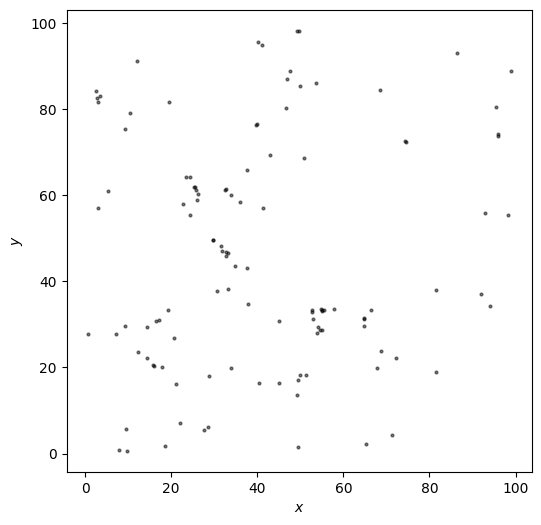

In [7]:
i_slice = (pos_arr_hMpc[:,2] < np.max(pos_arr_hMpc[:,2])/20)

plt.figure(figsize=(6, 6))
plt.scatter(pos_arr_hMpc[i_slice,0], pos_arr_hMpc[i_slice,1], color='k', s=4, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

### Load in ICS

In [8]:
seed = idx_sam + 5000 # from camels data gen
fn_pkic = f'/dipc/kstoreyf/CAMELS-SAM_ICS/LH/LH_{idx_sam}/Pk_m_z=0.000.txt'

In [9]:
k, pk = np.loadtxt(fn_pkic, unpack=True)

Text(0, 0.5, '$P(k)$')

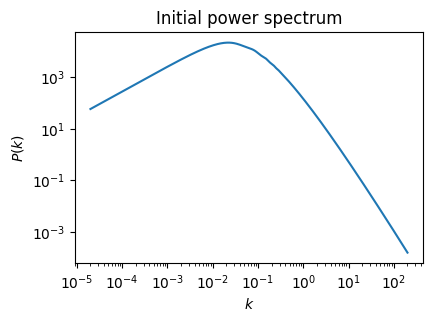

In [10]:
plt.figure(figsize=(4.5,3))
plt.title("Initial power spectrum")
plt.plot(k, pk)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [11]:
snapshot = f'/cosmos_storage/kstoreyf/CAMELS-SAM_ICS/LH/LH_{idx_sam}/ics'
#snapshot = '/dipc/kstoreyf/external/run_2lpt_example/ics_Carmen_2001'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

In [12]:
header   = readgadget.header(snapshot)

In [13]:
vars(header)

{'time': 0.0078125,
 'redshift': 127.0,
 'boxsize': 100000.0,
 'filenum': 12,
 'omega_m': 0.4322,
 'omega_l': 0.5678,
 'hubble': 0.6711,
 'massarr': array([0.     , 0.04576, 0.     , 0.     , 0.     , 0.     ]),
 'npart': array([       0, 22118400,        0,        0,        0,        0],
       dtype=int32),
 'nall': array([        0, 262144000,         0,         0,         0,         0],
       dtype=uint32),
 'cooling': 0,
 'format': 1,
 'Hubble': 95204.49895882022}

In [14]:
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [15]:
pos.shape

(262144000, 3)

In [16]:
rng = np.random.default_rng()
N_sample = int(1e6)
i_sample = rng.choice(np.arange(pos.shape[0]), size=N_sample, replace=False)
pos_sample = pos[i_sample,:]

Text(0, 0.5, '$y$')

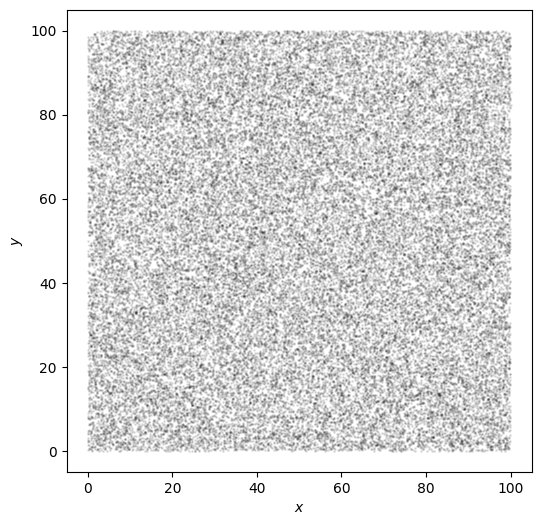

In [17]:
i_slice_sample = (pos_sample[:,2] < np.max(pos_sample[:,2])/20)

plt.figure(figsize=(6, 6))
plt.scatter(pos_sample[i_slice_sample,0], pos_sample[i_slice_sample,1], color='k', s=1, alpha=0.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

### get ICs on grid:

In [18]:
box_size = 100. #Mpc/h, camels
ngrid = 640

In [19]:
pos_mesh = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size, pos=pos, vel=vel, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)

2024-04-16 21:55:09,784 bacco.statistics : Computing cic mesh with ngrid=640 and interlacing=False
2024-04-16 21:55:09,785 bacco.statistics : starting deposit 1
2024-04-16 21:55:11,331 bacco.statistics :  mesh done in 1.55 s


bacco.mesh : boxsize=100.000000 ngrid=640, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 1000.0 Mb
bacco.mesh : binning of 262144000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [20]:
pos_mesh.shape, np.min(pos_mesh), np.max(pos_mesh)

((1, 640, 640, 640), 0.7352492, 1.5764357)

In [21]:
pos_mesh.shape

(1, 640, 640, 640)

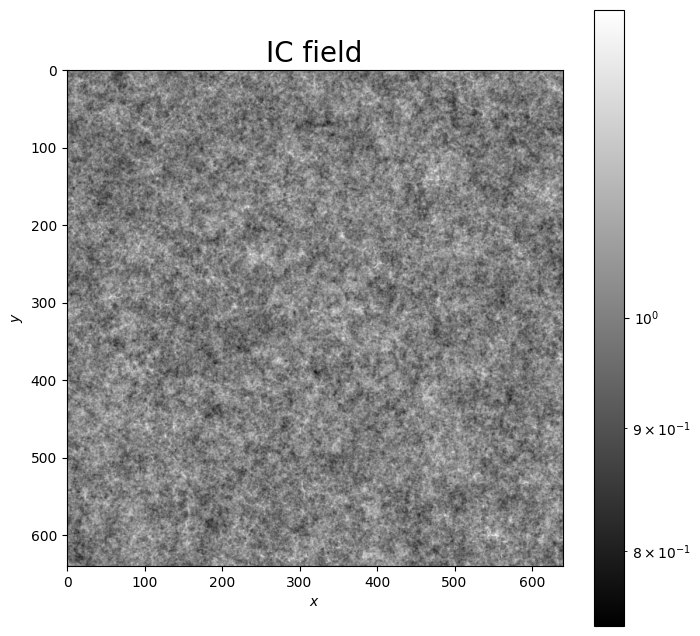

In [22]:
#norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.figure(figsize=(8,8))
plt.imshow(pos_mesh[0,0,:,:], norm='log', cmap='grey')
plt.colorbar()

# fac_rescale = ngrid/box_size 
# plt.scatter(fac_rescale*pos_arr_hMpc[i_slice,0], fac_rescale*pos_arr_hMpc[i_slice,1], color='c', s=8, alpha=1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

#plt.imshow(halo_field_eul[0,:,:])
plt.title(r'IC field', size=20)
plt.show()

In [33]:
def plot_tracer_field(tracer_field, to_overdensity=True, normalize=True, vmax=None, 
                      title=None, show_labels=True, show_colorbar=True,
                      slice_width=1, figsize=(6,6)):

        if to_overdensity:
            tracer_field = tracer_field/np.mean(tracer_field) - 1
        print(np.min(tracer_field), np.max(tracer_field))

        if normalize:
            tracer_field /= np.max(np.abs(tracer_field))
        print(np.min(tracer_field), np.max(tracer_field))
        
        if vmax is None:
            vmax = np.max(np.abs(tracer_field))
        print(vmax)
        
        linthresh = 0.1*vmax
        linscale = 1.0
        norm = SymLogNorm(
                linthresh=linthresh, linscale=linscale,
                vmin=-vmax, vmax=vmax
                )

        field_2d = np.mean(tracer_field[0:slice_width,:,:], axis=0)

        print(field_2d.shape, np.min(field_2d), np.max(field_2d))
        plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        plt.title(title, fontsize=16)
        

        im = plt.imshow(field_2d, norm=norm, cmap='RdBu')
        ax = plt.gca()        
        
        if show_colorbar:
            cbar = plt.colorbar(im, label=r'overdensity $\delta$', fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=12) 
            
        if not show_labels:    
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

-0.26475245 0.5764321
-0.4592951 1.0
1.0
(640, 640) -0.44306606 0.593678


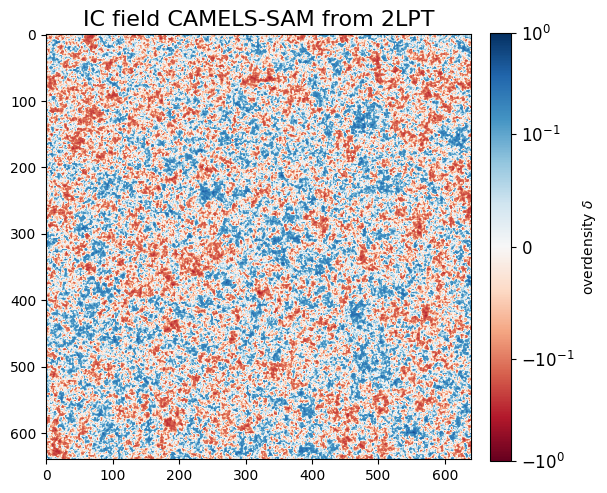

In [26]:
plot_tracer_field(pos_mesh[0], title=r'IC field CAMELS-SAM from 2LPT')

### try to replicate ICs with bacco.simulation 

In [27]:
fn_params_all = '../data/params_CAMELS-SAM.dat'
#params_all = np.loadtxt(fn_params_all, delimiter=',')
df_params = pd.read_csv(fn_params_all)
params = df_params.loc[idx_sam]
print(params)

idx_LH          0.00000
Omega_m         0.43220
sigma_8         0.86860
A_SN1_x1.7      0.56783
A_SN2_p3        3.99400
A_AGN_x0.002    0.00468
Name: 0, dtype: float64


In [28]:
a_Quijote = 1
# fixed params (https://camels-sam.readthedocs.io/en/main/simulations.html)
Ob = 0.049
hubble = 0.6711
ns = 0.9624
cosmopars = dict(
        omega_cdm=params['Omega_m']-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=params['sigma_8'],
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag=f"cosmo_LH{idx_sam}"
    )
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-04-16 21:56:23,911 bacco.cosmo :    initialization took 0.000 secs


In [29]:
# basedir = f'~/CAMELS-SAM_ICS/LH/LH_{idx_sam}/'
# dm_file = f'~/CAMELS-SAM_ICS/LH/LH_{idx_sam}/ics'
# pkfile = f'~/CAMELaS-SAM_ICS/LH/LH_{idx_sam}/Pk_m_z\=0.000.txt'
# print(pkfile)
# sim   = bacco.Simulation(basedir=None, 
#                          #dm_file=dm_file, 
#                          pkfile=pkfile, 
#                          sim_cosmology=cosmo_Quijote)

In [30]:
box_size = 100.
n_threads = 8
bacco.configuration.update({'scaling' : {'LPT_order' : 2}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : 640}})
bacco.configuration.update({'number_of_threads': n_threads})

linear_density = bacco.statistics.compute_linear_overdensity(cosmo_Quijote, box=box_size, seed=seed,
                                                             order_by_order=False)


2024-04-16 21:56:29,684 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.341 secs
2024-04-16 21:56:29,740 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-04-16 21:56:29,756 bacco.statistics : Generating linear field: Di=1.0


bacco.lss_scaler : 298 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5000 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5000 ngrid=640 pkfixed=1 phase=0.000000, phase_type=1; precision=single 
bacco.lss_scaler: Computing 2LPT density...
l2=-4.71396e-17 
l2=1.37677e-17 
l2=3.50857e-17 
l2=-2.13137e-17 
l2=-2.389e-17 
l2=7.5302e-18 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.70583e-08 l3a=4.48129e-08 l3b=1.22314e-07


In [31]:
print(linear_density.shape)
for i in range(linear_density.shape[0]):
    print(np.min(linear_density[i]), np.max(linear_density[i]))

(5, 640, 640, 640)
-1.5161258e-07 1.6188434e-07
-1.0002539e-06 2.4774056e-07
0.0 0.0
0.0 0.0
0.0 0.0


-1.5161258e-07 1.6188434e-07
-0.93654877 1.0
1.0
(640, 640) -0.8723474 0.8179199


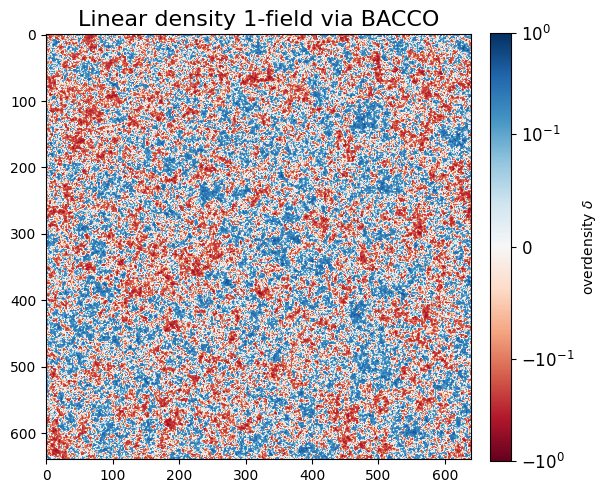

In [37]:
plot_tracer_field(linear_density[0], to_overdensity=False, title=r'Linear density 1-field via BACCO')

-1.0002539e-06 2.4774056e-07
-1.0 0.24767768
1.0
(640, 640) -0.81843877 0.2078884


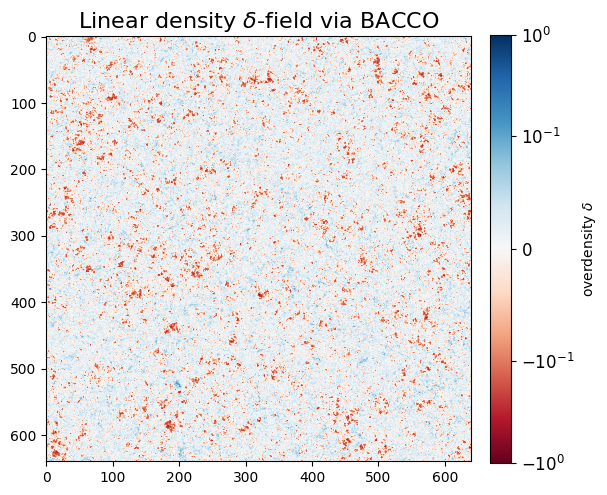

In [38]:
plot_tracer_field(linear_density[1], to_overdensity=False, title=r'Linear density $\delta$-field via BACCO')

trying diff way - but think above is best!

In [39]:
# CREATE A ZA SIMULATION
print("Generating LPT sim")
LPT_order = 2
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo_Quijote, box_size, Nmesh=ngrid, Seed=seed,
                                                    FixedInitialAmplitude=False,InitialPhase=0, 
                                                    expfactor=1, LPT_order=LPT_order, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-04-16 22:05:36,389 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-04-16 22:05:36,390 bacco.sims : Initialising simulation Default
2024-04-16 22:05:36,391 bacco.sims : ...done in 0.000893 s


Generating LPT sim


2024-04-16 22:05:37,214 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.235 secs
2024-04-16 22:05:37,214 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-04-16 22:05:53,687 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.227 secs
2024-04-16 22:05:53,722 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 298 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5000 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5000 ngrid=640 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss_scaler: Computing 2LPT density...
l2=-4.06289e-17 
l2=-3.07617e-19 
l2=3.16885e-17 
l2=-3.83315e-18 
l2=-3.67944e-17 
l2=2.99914e-17 
bacco.lss_scaler: Fourier transforming second order source...
l2=-6.36958e-08 l3a=7.95239e-08 l3b=9.14132e-08


2024-04-16 22:06:42,847 bacco.scaler : Adding displacement field with a vel-factor=62.943811


bacco.lss_scaler:  Adding LSS displacement: vel_factor=62.943811 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [41]:
disp_field.shape

(3, 640, 640, 640)

In [42]:
box_size, ngrid

(100.0, 640)

In [49]:
linear_field_sim = sim.linear_field
print(linear_field_sim.shape)
for i in range(linear_field_sim.shape[0]):
    print(np.min(linear_field_sim[i]), np.max(linear_field_sim[i]))

(5, 640, 640, 640)
-0.90499985 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


only the first part is nonzero!!

In [50]:
dens_lin = linear_field_sim[0]
dens_lin.shape

(640, 640, 640)

-0.90499985 1.0
-0.90499985 1.0
1.0
(640, 640) -0.80667627 0.7757947


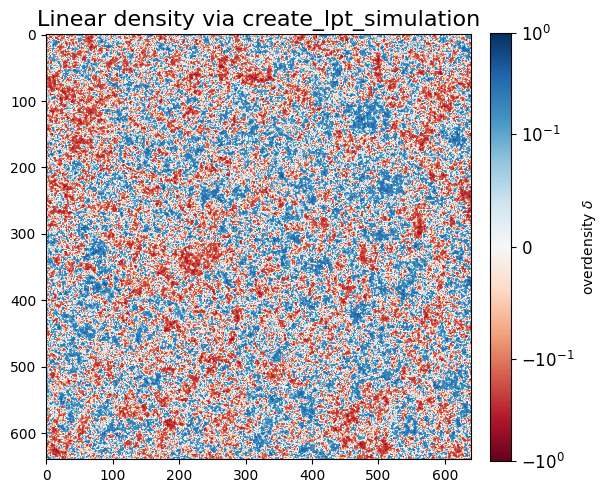

In [51]:
plot_tracer_field(dens_lin, to_overdensity=False, title=r'Linear density via create_lpt_simulation')

## mess below here

In [84]:
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=ngrid, L=box_size, ndim=3, bounds=False)

print("Adding displacements")
pos_sim = bacco.scaler.add_displacement(None,
                                    disp_field,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-04-15 18:39:15,126 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [85]:
grid.shape, ngrid

((640, 640, 640, 3), 640)

In [90]:
pos_grid = grid.T
pos_mesh_sim = pos_grid + disp_field

In [110]:
# ??
pos_mesh_sim = bacco.statistics.compute_density_from_displacements(disp_field, box=box_size, eulerian=False)

bacco.lss_scaler: Fourier transforming vector, axis 0
bacco.lss_scaler: Fourier transforming vector, axis 1
bacco.lss_scaler: Fourier transforming vector, axis 2


-1.0423514759168029e-06 2.5015612482093277e-07
-6.578010611031514e-19
-1.0423514759168029e-06 2.5015612482093277e-07


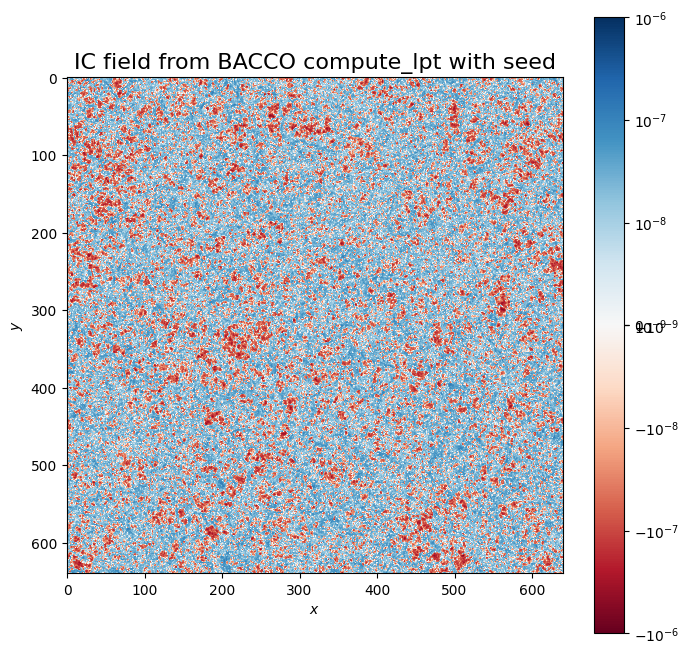

In [109]:
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=1e-9, linscale=1e-9, vmin=-1e-6, vmax=1e-6)

#Plot 1-term
plt.figure(figsize=(8,8))
#field_mean_sim = np.mean(pos_mesh_sim)
#pos_mesh_overdensity_sim = pos_mesh_sim/field_mean-1
pos_mesh_overdensity_sim = pos_mesh_sim
#print(field_mean_sim)
print(np.min(pos_mesh_sim), np.max(pos_mesh_sim))
print(np.mean(pos_mesh_overdensity_sim))
print(np.min(pos_mesh_overdensity_sim), np.max(pos_mesh_overdensity_sim))
plt.imshow(pos_mesh_overdensity_sim[0,:,:], norm=norm, cmap='RdBu')
plt.colorbar()

# fac_rescale = ngrid/box_size 
# plt.scatter(fac_rescale*pos_arr_hMpc[i_slice,0], fac_rescale*pos_arr_hMpc[i_slice,1], color='c', s=8, alpha=1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

#plt.imshow(halo_field_eul[0,:,:])
plt.title(r'IC field from BACCO compute_lpt with seed', size=16)
plt.show()

In [113]:
#TODO include vel??
pos_mesh_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size, pos=pos_sim, vel=None, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)

2024-04-16 18:47:15,026 bacco.statistics : Computing cic mesh with ngrid=640 and interlacing=False
2024-04-16 18:47:15,027 bacco.statistics : starting deposit 1
2024-04-16 18:47:17,254 bacco.statistics :  mesh done in 2.23 s


bacco.mesh : boxsize=100.000000 ngrid=640, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 1000.0 Mb
bacco.mesh : binning of 262144000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [114]:
pos_mesh_sim.shape

(1, 640, 640, 640)

0.9999983
0.0 56.107925
-1.0 55.108093


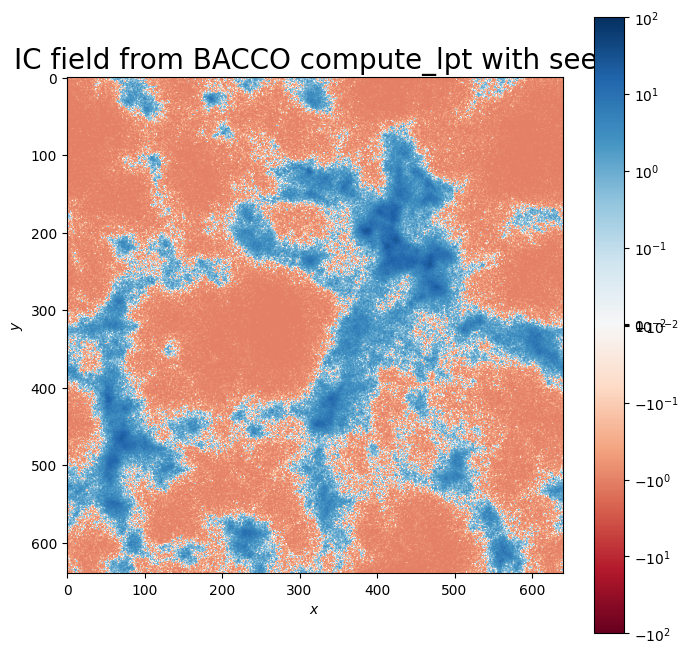

In [117]:
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.01, linscale=0.01, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.figure(figsize=(8,8))
field_mean_sim = np.mean(pos_mesh_sim)
pos_mesh_overdensity_sim = pos_mesh_sim/field_mean-1
print(field_mean_sim)
print(np.min(pos_mesh_sim), np.max(pos_mesh_sim))

print(np.min(pos_mesh_overdensity_sim), np.max(pos_mesh_overdensity_sim))
plt.imshow(pos_mesh_overdensity_sim[0,0,:,:], norm=norm, cmap='RdBu')
plt.colorbar()

# fac_rescale = ngrid/box_size 
# plt.scatter(fac_rescale*pos_arr_hMpc[i_slice,0], fac_rescale*pos_arr_hMpc[i_slice,1], color='c', s=8, alpha=1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

#plt.imshow(halo_field_eul[0,:,:])
plt.title(r'IC field from BACCO compute_lpt with seed', size=20)
plt.show()

## prob bias

In [129]:
variables = ("J2", "J4")
damping_scale = 0.75
pbm = pb.ProbabilisticBiasManager(None, variables=variables, damping_scale=damping_scale, ngrid=ngrid,
                                 tocache=(), # jens told me not to cache things when loading in my own sim
                                 ) 

In [137]:
pbm.kmin, pbm.kmax, pbm.damping_scale

(0.0, 10000000000.0, 0.75)

In [138]:
# TODO i think im supposed to do the smoothing myself in this case? see jens slack message
# oh i think damping scale is smoothing scale... just think about what it should be. "param damping_scale: Smoothing scale wavelength"
kmin = 0.75 #pbm.kmin
kmax = 10
pbm.setup_linear_fields(ngrid=pbm.ngrid, damping_scale=pbm.damping_scale, kmin=kmin, kmax=kmax,
                        delta=pos_mesh, box_size=box_size)

In [139]:
pbm.fields_initialized

True

Cool it knew that we initialized the fields, so we can still call pbm.setup_bias_model as before:

In [140]:
# "J2" corresponds to b1, "J22" to b2, "J24" to bdeltaL (not in Matteo's), "J4" to bL (nabla^2 delta), "J44" to bL**2 (s^2)
#terms = ("J2", "J22", "J4", "J44")
terms = ("J2", "J4")
model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=4)

In [141]:
# looked thru code, reproducing here to be able to do without a sim
tracer_q = pos_arr_hMpc
dm_field_ip = pbm._create_interpolator(pbm.dm_field)
tracer_value = dm_field_ip(tracer_q)

In [142]:
tracer_q.shape, tracer_value.shape

((2999, 3), (2999, 2))

In [143]:
b, bcov = pbm.fit_bias(model=model_expansion, tracer_q=tracer_q, tracer_value=tracer_value,
                       mask=None, error="jack4")

print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))
#print("bL = %.2f +- %.2f" % (b[2], np.sqrt(bcov[2,2])))
#print("bs2 = %.2f +- %.2f" % (b[3], np.sqrt(bcov[3,3])))

(2999, 3) (2999, 2)
b1 = 52.64 +- 0.06
b2 = 0.94 +- 0.00


In [98]:
bcov

array([[3.52345688e-03, 3.71945192e-01, 5.87691308e-05, 1.09629524e-04],
       [3.71945192e-01, 3.92730693e+01, 6.21403847e-03, 1.15947550e-02],
       [5.87691308e-05, 6.21403847e-03, 1.53637165e-06, 2.85914353e-06],
       [1.09629524e-04, 1.15947550e-02, 2.85914353e-06, 5.32804404e-06]])